In [3]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [5]:
csv_dir = '../my-data'
dfs_1, dfs_2 = [], []
for csv in os.listdir(csv_dir):
    df = pd.read_csv(os.path.join(csv_dir, csv), index_col=0, dtype=float)
    df.drop(columns=["0.5"], inplace=True)
    if csv.endswith('1.csv'):
        dfs_1.append(df)
    elif csv.endswith('2.csv'):
        dfs_2.append(df)

chiller_temps = [pd.concat(dfs) for dfs in zip(dfs_1, dfs_2)]
df_concat = pd.concat(chiller_temps)
df_grouped = df_concat.groupby(df_concat.index)
avg_temp = df_grouped.mean()
avg_temp.loc[360] = avg_temp.loc[0].values
avg_temp.head(13)

,1.25,2.0,2.75,3.5,4.25,5.0,5.75,6.5,7.25
0.0,1.360195,1.303995,1.906685,2.800230,3.331275,4.389140,5.096230,5.120160,5.192810
30.0,1.243320,2.047050,2.623735,2.867975,2.898135,3.044935,3.667295,4.119930,4.673945
60.0,2.101070,2.290080,2.798130,3.093140,3.340425,3.388685,3.614315,4.015890,4.392805
90.0,1.531960,1.745265,1.866900,2.135470,2.318210,2.345640,2.346175,2.316240,2.505455
120.0,1.898960,2.623795,3.038300,3.067085,3.002945,2.915115,2.791730,2.651570,2.513745
150.0,1.658845,2.332325,2.845960,2.949025,2.898245,2.760440,2.587580,2.448930,2.318640
180.0,1.661300,2.186055,2.747570,2.866275,2.688655,2.466415,2.270890,2.071465,1.916750
210.0,1.871490,2.350715,2.860840,2.931900,2.885025,2.757755,2.593155,2.459255,2.331885
240.0,1.844275,2.661605,3.076510,3.100475,3.050430,2.957820,2.814555,2.664830,2.521300
270.0,1.542910,1.748045,1.835750,2.080900,2.256055,2.264615,2.390740,2.438800,2.612885


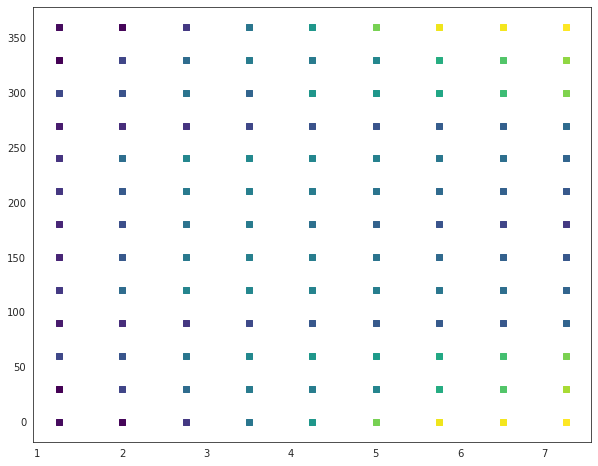

In [6]:
nx1 = 30
nx2 = 1
X1_obs = [float(i) for i in avg_temp.columns.tolist()]
X2_obs = [float(i) for i in avg_temp.index.tolist()]
x1, x2 = np.meshgrid(X1_obs, X2_obs)
x11 = sum(x1.tolist(), [])
x22 = sum(x2.tolist(), [])
# x1, x2 = np.meshgrid(np.linspace(0,360,nx1), np.linspace(0,8,nx2))
# X = np.concatenate([x1.reshape(nx1*nx2, 1), x2.reshape(nx1*nx2, 1)], 1)

# X1_obs = chiller_temp.columns.tolist()
# X2_obs = chiller_temp.index.tolist()
y_obs = sum(avg_temp.values.tolist(), [])

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(x11, x22, c=y_obs, marker='s', cmap=plt.cm.viridis);

In [7]:
X_obs = np.concatenate([x1.reshape(len(x1)*len(x1[0]), 1), x2.reshape(len(x2)*len(x2[0]), 1)], axis=1)

In [8]:
RANDOM_SEED = 42
CHAINS = 2

In [9]:
with pm.Model() as model_1:
    
    # l1 = pm.StudentT("l1", nu=5, mu=3, sigma=2)
    l1_1 = pm.Normal("l1", mu=3, sigma=1)
    # l2 = pm.StudentT("l2", nu=15, mu=30, sigma=10)
    l2_1 = pm.Normal("l2", mu=30, sigma=2)
    sf_1 = pm.HalfCauchy("sf", 2)
    sn_1 = pm.HalfNormal("sn", 0.2)

    #M = pm.gp.mean.Constant([2.5])
    M_1 = pm.gp.mean.Zero()
    K_1 = pm.gp.cov.ExpQuad(2, [l1_1, l2_1]) * sf_1**2
    
    gp_chillers_1 = pm.gp.Marginal(mean_func=M_1, cov_func=K_1)
    obs_1 = gp_chillers_1.marginal_likelihood("obs_1", X=X_obs, y=y_obs, noise=sn_1)

    # mp = pm.find_MAP()

In [10]:
with pm.Model() as model_2:
    
    #l1_2 = pm.Normal("l1", mu=5, sigma=2)
    #l1_2 = pm.ChiSquared("l1", nu=6)
    #l1_2 = pm.ExGaussian("l1", mu=5, sigma=2, nu=1)
    #l1_2 = pm.Gamma("l1", mu=5, sigma=3)
    l1_2 = pm.Rice("l1", nu=3, sigma=1)
    #l2_2 = pm.Normal("l2", mu=40, sigma=10)
    #l2_2 = pm.ChiSquared("l2", nu=15)
    #l2_2 = pm.ExGaussian("l2", mu=40, sigma=10, nu=1)
    #l2_2 = pm.Gamma("l2", mu=30, sigma=10)
    l2_2 = pm.Rice("l2", nu=30, sigma=4)
    #sf_2 = pm.HalfCauchy("sf", 2)
    #sf_2 = pm.HalfStudentT("sf", sigma=3, nu=1)
    sf_2 = pm.Rice("sf", nu=0, sigma=2)
    sn_2 = pm.HalfNormal("sn", 0.2)

    #M = pm.gp.mean.Constant([2.5])
    M_2 = pm.gp.mean.Zero()
    K_2 = pm.gp.cov.ExpQuad(2, [l1_2, l2_2]) * sf_2**2
    
    gp_chillers_2 = pm.gp.Marginal(mean_func=M_2, cov_func=K_2)
    obs_2 = gp_chillers_2.marginal_likelihood("obs_2", X=X_obs, y=y_obs, noise=sn_2)

In [11]:
with model_1:
    gp_trace_1 = pm.sample(1000, tune=2000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [sn, sf, l2, l1]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 44 seconds.


In [12]:
with model_2:
    gp_trace_2 = pm.sample(1000, tune=2000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED)

WARNING (theano.tensor.opt): Optimization Warning: The Op i0e does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.opt): Optimization Warning: The Op i1e does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Multiprocess sampling (2 chains in 8 jobs)
NUTS: [sn, sf, l2, l1]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 47 seconds.


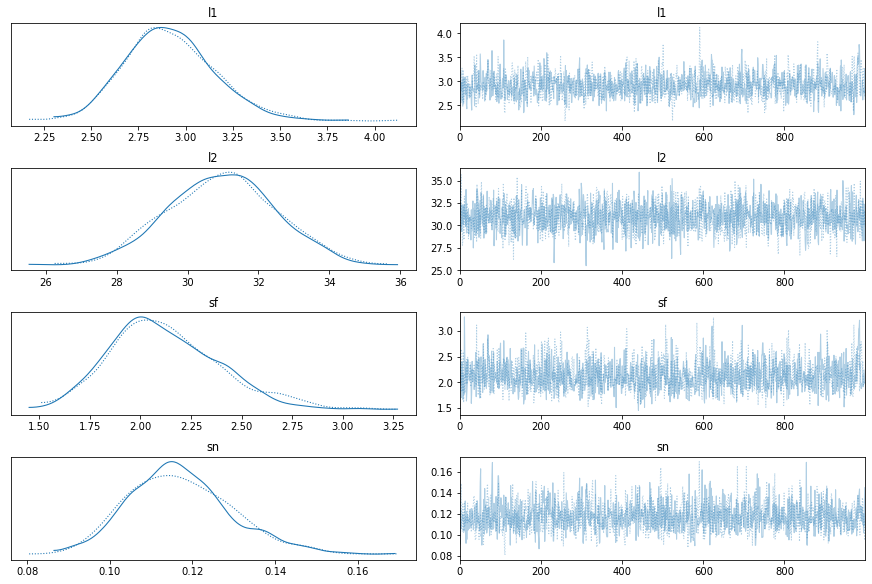

In [13]:
az.plot_trace(gp_trace_1, var_names=['l1', 'l2', 'sf', 'sn']);

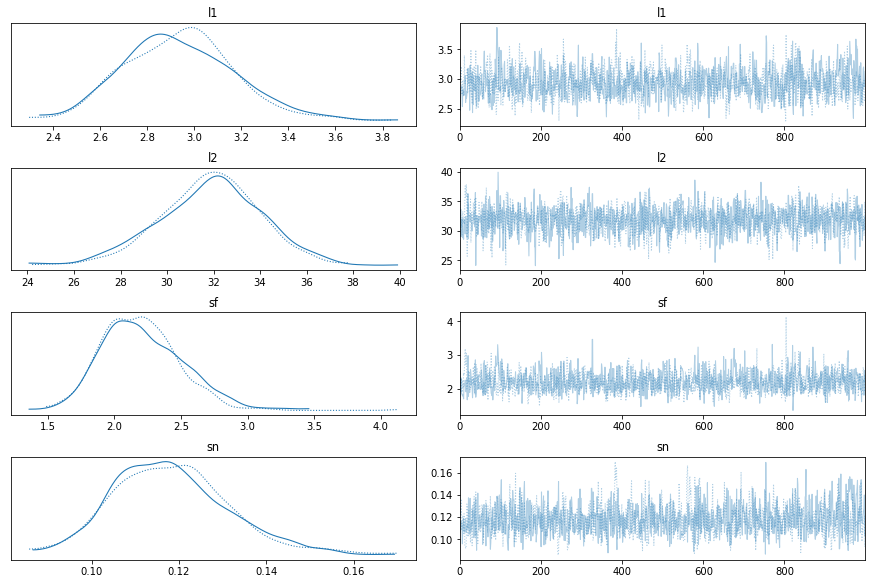

In [14]:
az.plot_trace(gp_trace_2, var_names=['l1', 'l2', 'sf', 'sn']);

array([<AxesSubplot:title={'center':'l1'}>,
       <AxesSubplot:title={'center':'l2'}>,
       <AxesSubplot:title={'center':'sf'}>,
       <AxesSubplot:title={'center':'sn'}>], dtype=object)

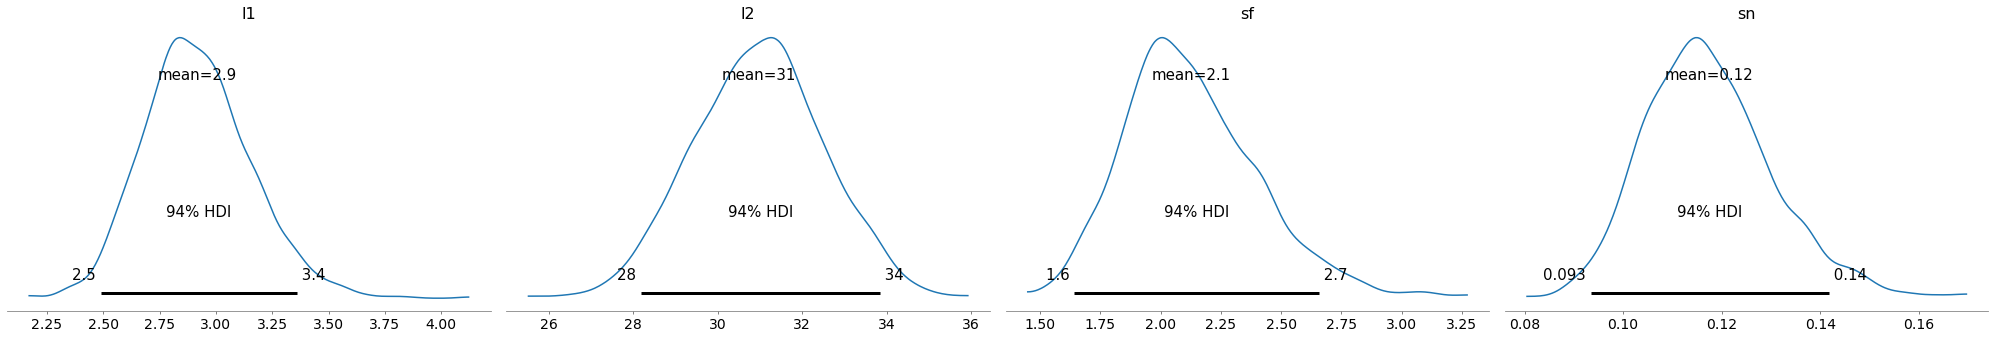

In [15]:
az.plot_posterior(gp_trace_1)

array([<AxesSubplot:title={'center':'l1'}>,
       <AxesSubplot:title={'center':'l2'}>,
       <AxesSubplot:title={'center':'sf'}>,
       <AxesSubplot:title={'center':'sn'}>], dtype=object)

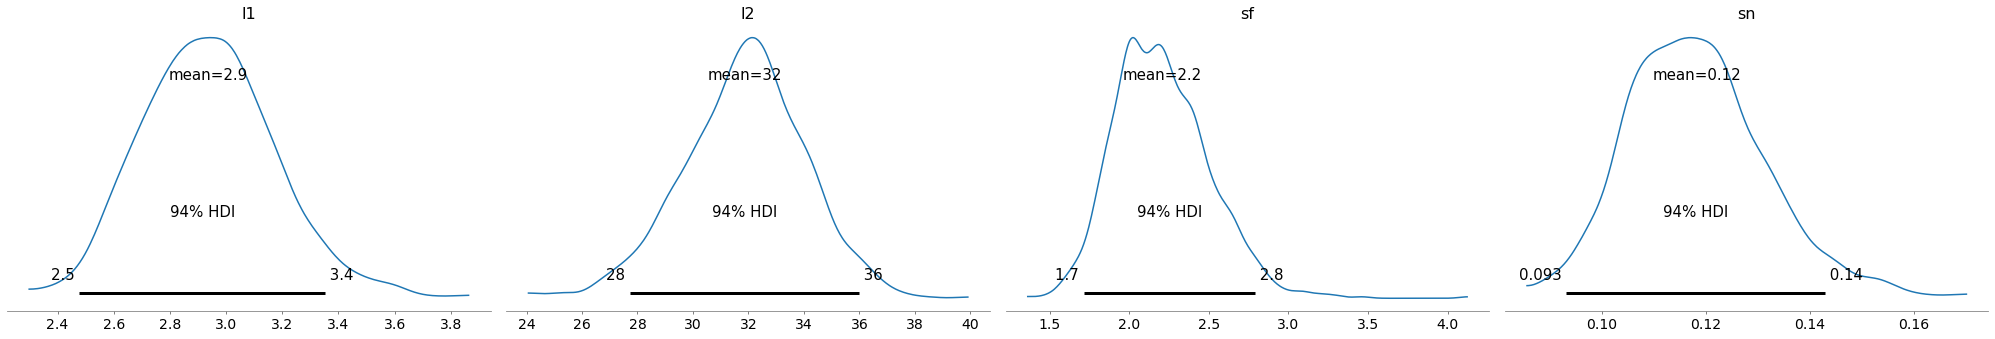

In [16]:
az.plot_posterior(gp_trace_2)

array([<AxesSubplot:title={'center':'94.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

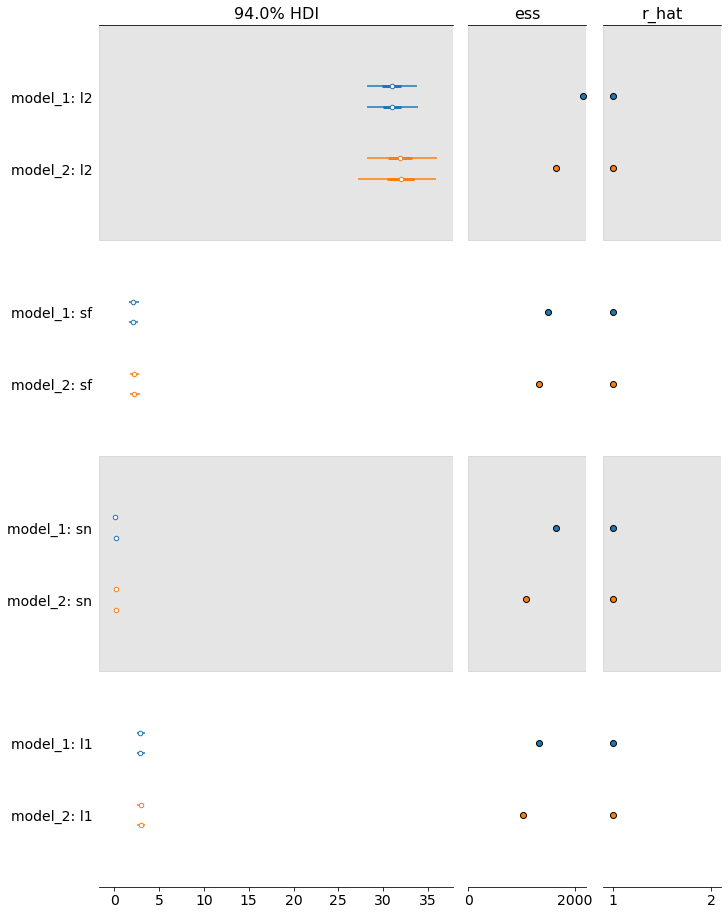

In [17]:
az.plot_forest([gp_trace_1, gp_trace_2], model_names=['model_1', 'model_2'], ess=True, r_hat=True)

In [18]:
az.summary(gp_trace_1, round_to=3, var_names=['l1', 'l2', 'sf', 'sn'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l1,2.916,0.238,2.488,3.358,0.007,0.005,1366.742,1188.669,1.001
l2,30.970,1.535,28.188,33.840,0.033,0.023,2166.498,1582.121,1.000
sf,2.127,0.280,1.642,2.657,0.007,0.005,1694.466,1112.647,1.000
sn,0.117,0.013,0.093,0.142,0.000,0.000,1668.074,1242.086,1.001


In [19]:
az.summary(gp_trace_2, round_to=3, var_names=['l1', 'l2', 'sf', 'sn'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
l1,2.938,0.237,2.477,3.353,0.007,0.005,1061.586,1108.875,1.002
l2,31.860,2.189,27.737,35.996,0.054,0.038,1650.650,1194.880,1.002
sf,2.204,0.298,1.714,2.788,0.008,0.006,1438.454,955.093,1.003
sn,0.118,0.013,0.093,0.143,0.000,0.000,1234.302,787.653,1.001


In [20]:
loo_1 = az.loo(gp_trace_1, model_1)
loo_1.loo

-44.9537153084867

In [21]:
loo_2 = az.loo(gp_trace_2, model_2)
loo_2.loo

-44.85867097121772

In [22]:
df_comp_loo = az.compare({"model_1": gp_trace_1, "model_2": gp_trace_2})
df_comp_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_2,0,-44.858671,2.512858,0.000000,1.0,0.0,0.0,True,log
model_1,1,-44.953715,2.605474,0.095044,0.0,0.0,0.0,True,log


In [23]:
nv = 50
nd = 70
ws = np.linspace(0.5, 8, nv)
wd = np.linspace(10, 350, nd)
t1, t2 = np.meshgrid(ws, wd)
T = np.concatenate([t1.reshape(len(t1)*len(t1[0]), 1), t2.reshape(len(t2)*len(t2[0]), 1)], axis=1)

In [24]:
with model_1:

    f_pred_1 = gp_chillers_1.conditional('f_pred_1', T)
    
    samples_1 = pm.sample_posterior_predictive([gp_trace_1], var_names=['f_pred_1'], random_seed=RANDOM_SEED, samples=100)

In [25]:
with model_2:

    f_pred_2 = gp_chillers_2.conditional('f_pred_2', T)
    
    samples_2 = pm.sample_posterior_predictive([gp_trace_2], var_names=['f_pred_2'], random_seed=RANDOM_SEED, samples=100)

In [26]:
s_1 = samples_1['f_pred_1'].mean(axis=0).reshape(nd, nv)
sd_1 = samples_1['f_pred_1'].std(axis=0).reshape(nd, nv)
s_2 = samples_2['f_pred_2'].mean(axis=0).reshape(nd, nv)
sd_2 = samples_2['f_pred_2'].std(axis=0).reshape(nd, nv)

Text(0.5, 1.0, 'Predictions - model_1')

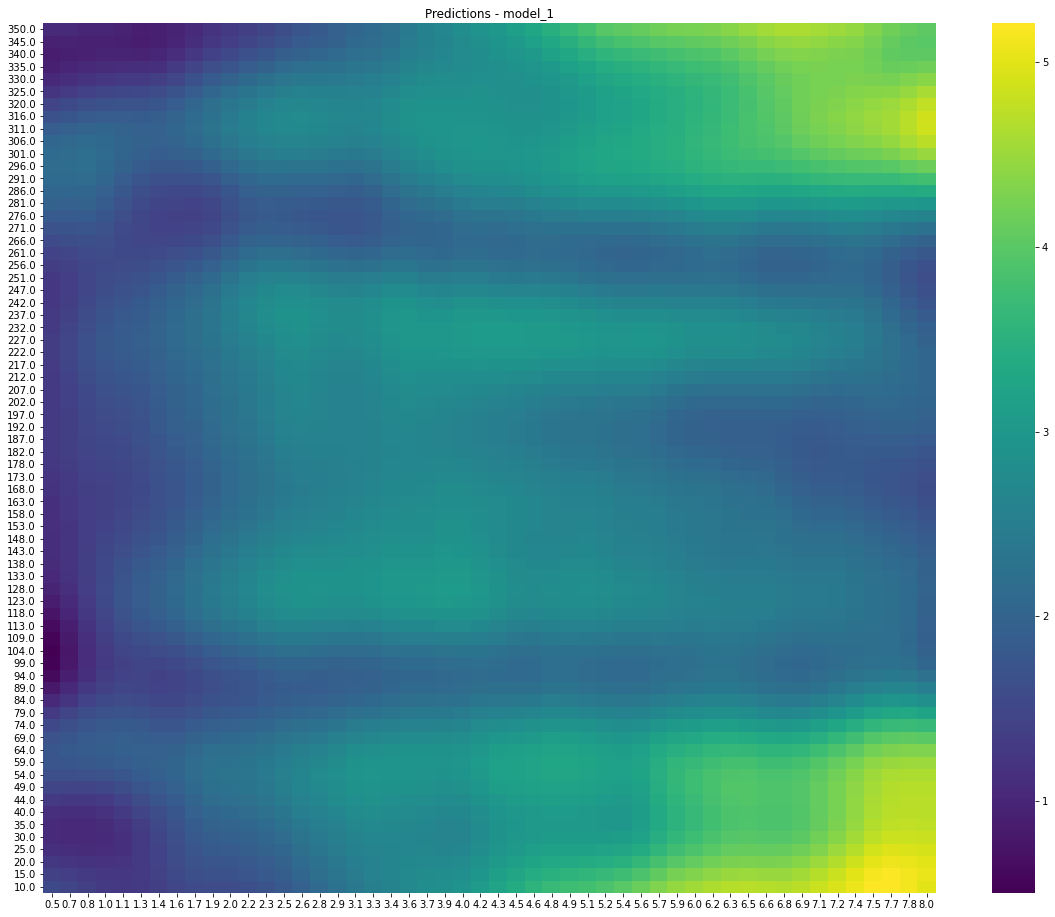

In [27]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(s_1, cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Predictions - model_1')

Text(0.5, 1.0, 'Predictions - model_2')

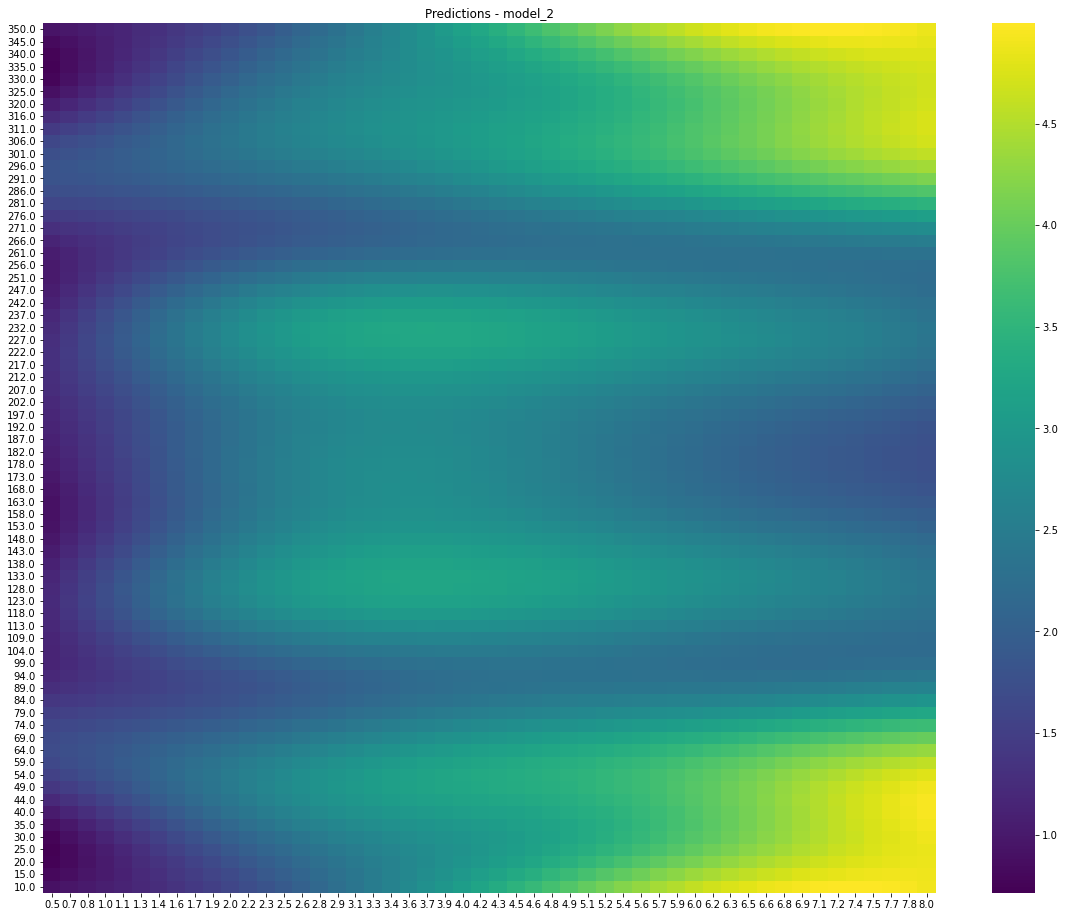

In [28]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(s_2, cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Predictions - model_2')

Text(0.5, 1.0, 'Uncertainty - model_1')

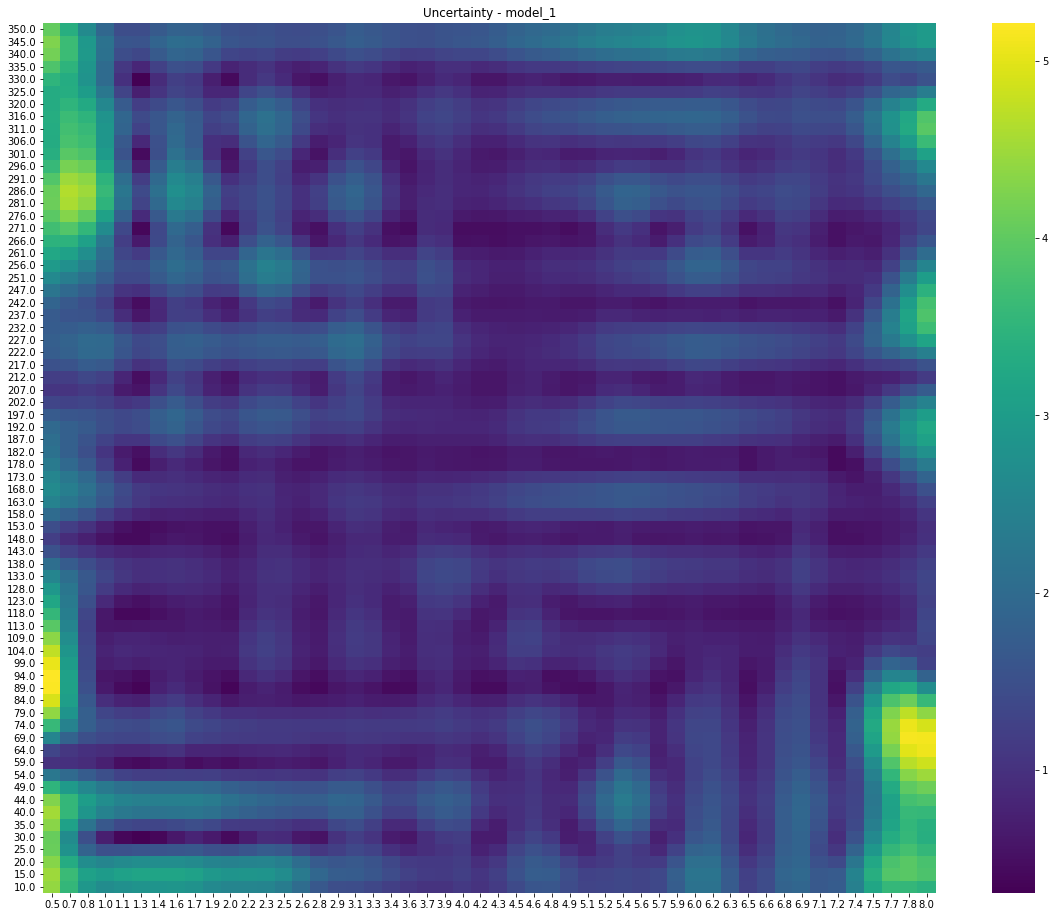

In [29]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(sd_1, cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Uncertainty - model_1')

Text(0.5, 1.0, 'Uncertainty - model_2')

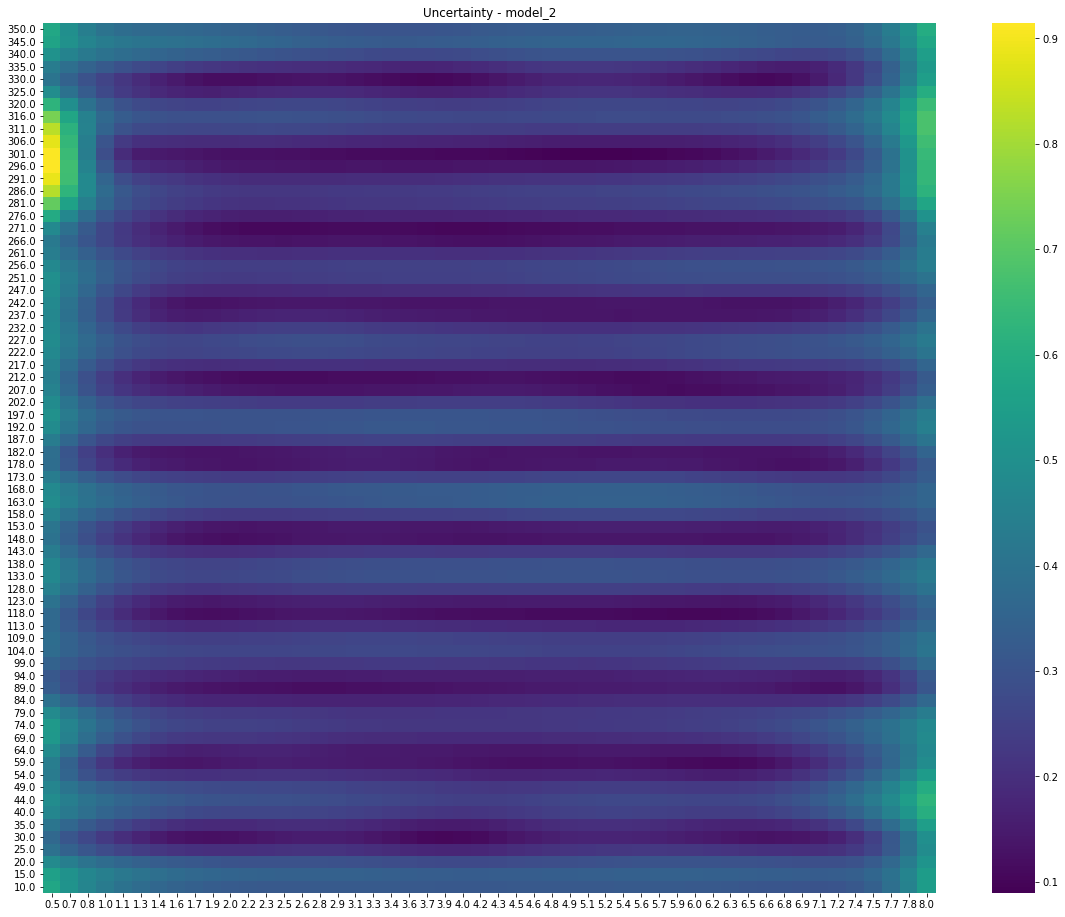

In [30]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(sd_2, cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Uncertainty - model_2')